In [21]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import butter, filtfilt, hilbert, convolve
import mne

Extracting EDF parameters from /Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/sub-01_ses-01_task-verbalWM_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 799999  =      0.000 ...   400.000 secs...
Extracting EDF parameters from /Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/sub-01_ses-01_task-verbalWM_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 799999  =      0.000 ...   400.000 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: mAHL1, mAHL2, mAHL3, mAHL4, mAHL5, mAHL6, mAHL7, mAHL8, mAL1, ...
 chs: 48 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2023-09-13 10:27:08 UTC
 nchan: 48
 projs: []
 sfreq: 2000.0 Hz
 subject_info: <subject_info | his_id: <no>
>
Trials: 400, Samples per trial: 2000, fs=2000.0 Hz, trial_len=1.0s
Global PLV across all trials/time


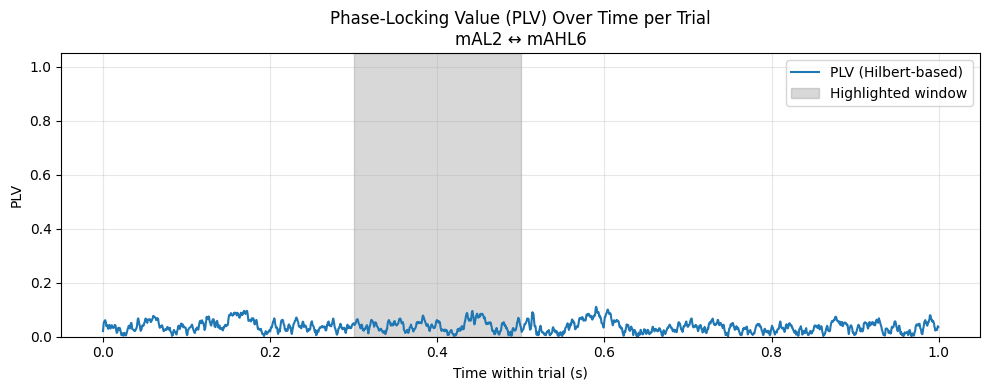

In [ ]:
# Load EDF file
raw = mne.io.read_raw_edf("/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/sub-01_ses-01_task-verbalWM_run-01_ieeg.edf", preload=True)

# === Compute Phase-Locking Value (PLV) on your EDF (MNE) ===


# Frequency of interest and band 

low_band = (12, 30)    # low-frequency band (e.g., beta)
high_band = (70, 250)  # high-frequency band (e.g., high gamma)

# Trialization of continuous data:
trial_len_sec = 1.0     # length of each trial in seconds   (e.g., 1.0)
step_sec      = 1.0     # step between trials in seconds    (e.g., 1.0 for non-overlapping)

# Optional: a "bell" interval to highlight on the plot (purely visual)
bell_window = (0.3, 0.5)   # in seconds within a trial; set to None to disable

# ---------------------------------------------------------
# ==== Step 1: Load EDF and import signals ====
# ---------------------------------------------------------
raw = mne.io.read_raw_edf('/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/sub-01_ses-01_task-verbalWM_run-01_ieeg.edf', preload=True)
fs  = float(raw.info["sfreq"])   # your file seems to be 2000 Hz
print(raw.info)

# Select two channels for PLV computation
ch_name_1 = raw.ch_names[0]
ch_name_2 = raw.ch_names[1]

# Pull channels as 1D arrays (n_samples,)
ch1 = raw.get_data(picks=[0]).squeeze()
ch2 = raw.get_data(picks=[1]).squeeze()

# (optional) Demean to reduce edge/filter artifacts
ch1 = ch1 - np.mean(ch1)
ch2 = ch2 - np.mean(ch2)

# Build trial matrix from continuous signals
def make_trials(x, fs, trial_len_sec, step_sec):
    n = len(x)
    win = int(round(trial_len_sec * fs))
    step = int(round(step_sec * fs))
    starts = np.arange(0, n - win + 1, step, dtype=int)
    trials = np.stack([x[s:s+win] for s in starts], axis=0) if len(starts) > 0 else np.empty((0, win))
    return trials, starts

s1_trials, s_idx = make_trials(ch1, fs, trial_len_sec, step_sec)
s2_trials, _    = make_trials(ch2, fs, trial_len_sec, step_sec)

if s1_trials.shape[0] == 0:
    raise ValueError("No trials created. Try reducing trial_len_sec or step_sec.")

n_trials, n_samples = s1_trials.shape
time = np.arange(n_samples) / fs
duration = trial_len_sec  # per-trial duration

print(f"Trials: {n_trials}, Samples per trial: {n_samples}, fs={fs} Hz, trial_len={trial_len_sec}s")

# ---------------------------------------------------------
# ==== Step 2: Bandpass Filter using Butterworth filter ====
# ---------------------------------------------------------
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    # data expected shape: (n_trials, n_samples)
    return np.array([filtfilt(b, a, trial) for trial in data])

lf_filtered = bandpass_filter(s1_trials, low_band[0], low_band[1], fs)
hf_filtered = bandpass_filter(s2_trials, high_band[0], high_band[1], fs)

# ---------------------------------------------------------
# ==== Step 3: Hilbert transform → instantaneous phase ====
# ---------------------------------------------------------
analytic_lf = np.array([hilbert(trial) for trial in lf_filtered])
analytic_hf = np.array([hilbert(trial) for trial in hf_filtered])

phase_lf = np.angle(analytic_lf)   # shape (n_trials, n_samples)
amp_hf = np.abs(analytic_hf)   # shape (n_trials, n_samples)

analytic_hf_abs = np.array([hilbert(trial) for trial in amp_hf])
phase_hf = np.angle(analytic_hf_abs)   # shape (n_trials, n_samples)

# ---------------------------------------------------------
# ==== Step 4: Phase difference and PLV over trials ====
# ---------------------------------------------------------
phase_diff = phase_lf - phase_hf             # u(t,n) = phase1 - phase2
plv = np.abs(np.mean(np.exp(1j * phase_diff), axis=0))   # time-resolved PLV across trials

# (Optional) single summary PLV over the whole trial window:
plv_global = float(np.abs(np.mean(np.exp(1j * phase_diff))))
print(f"Global PLV across all trials/time")

# ---------------------------------------------------------
# ==== Step 5: Plot ====
# ---------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(time, plv, label=f'PLV (Hilbert-based)')
if bell_window is not None:
    plt.axvspan(bell_window[0], bell_window[1], color='gray', alpha=0.3, label='Highlighted window')
plt.title(f'Phase-Locking Value (PLV) Over Time per Trial\n{ch_name_1} ↔ {ch_name_2}')
plt.xlabel('Time within trial (s)')
plt.ylabel('PLV')
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

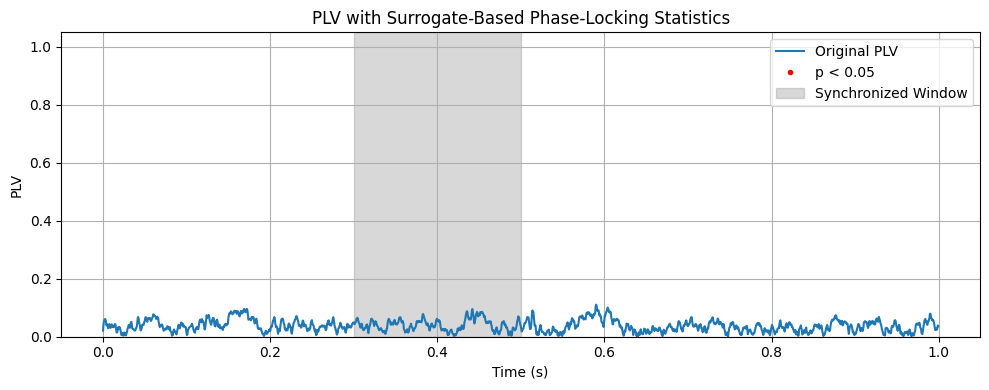

In [19]:
# Compute Phase locking statistics (PLS)
# H0: The phase difference between signals 1 and 2 is independent across trials (i.e., no real coupling).

# ==== Step 1: Generate Surrogate PLV Distributions ====
n_surrogates = 200  # Number of surrogate shuffles
surrogate_plvs = []
# Progress bar to track iterations
for _ in range(n_surrogates):

    # Step 1a: Shuffle the trial order of s2
    shuffled_indices = np.random.permutation(n_trials)
    phase_hf_shuffled = phase_hf[shuffled_indices, :]  # trial-wise shuffle

    # Step 1b: Compute phase difference with shuffled s2
    phase_diff_surrogate = phase_lf - phase_hf_shuffled

    # Step 1c: Compute PLV for the surrogate
    surrogate_plv = np.abs(np.mean(np.exp(1j * phase_diff_surrogate), axis=0))
    surrogate_plvs.append(surrogate_plv)


# Step 1d: Convert list to 2D array 
surrogate_plvs = np.array(surrogate_plvs)  # shape: (n_surrogates, n_samples)


# ==== Step 2: Compute Phase-Locking Statistics (PLS) ====
# Step 2a: Take max PLV from each surrogate across time
surrogate_max_per_trial = np.max(surrogate_plvs, axis=1)  # shape: (n_surrogates,)

# Step 2b: For each time point, compute p-value:
pls = np.array([
    np.mean(surrogate_max_per_trial >= plv_t)
    for plv_t in plv
])  # shape: (n_samples,)

# Step 2c: Mark significant points
significant_mask = pls < 0.05


# Plot 
plt.figure(figsize=(10, 4))
plt.plot(time, plv, label='Original PLV')
plt.plot(time[significant_mask], plv[significant_mask], 'r.', label='p < 0.05')
plt.axvspan(0.3, 0.5, color='gray', alpha=0.3, label='Synchronized Window')
plt.title('PLV with Surrogate-Based Phase-Locking Statistics')
plt.xlabel('Time (s)')
plt.ylabel('PLV')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

### channel_names = raw.ch_names

channel_names = raw.ch_names[:6]  # only first 6 channels → 15 pairs

# Frequency bands
low_band = (12, 30)    # Low-frequency band (e.g., beta)
high_band = (70, 250)  # High-frequency band (e.g., high gamma)

# Trialization parameters
trial_len_sec = 1.0
step_sec = 1.0

# Function to create trials
def make_trials(x, fs, trial_len_sec, step_sec):
    n = len(x)
    win = int(round(trial_len_sec * fs))
    step = int(round(step_sec * fs))
    starts = np.arange(0, n - win + 1, step, dtype=int)
    trials = np.stack([x[s:s+win] for s in starts], axis=0) if len(starts) > 0 else np.empty((0, win))
    return trials, starts

# Bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return np.array([filtfilt(b, a, trial) for trial in data])

# Iterate over all channel pairs
significant_couples = []
for i, ch_name_1 in enumerate(channel_names):
    for j, ch_name_2 in enumerate(channel_names):
        if i >= j:  # Avoid duplicate pairs and self-coupling
            continue

        # Extract and preprocess data
        ch1 = raw.get_data(picks=[i]).squeeze()
        ch2 = raw.get_data(picks=[j]).squeeze()
        ch1 = ch1 - np.mean(ch1)
        ch2 = ch2 - np.mean(ch2)

        # Create trials
        s1_trials, _ = make_trials(ch1, fs, trial_len_sec, step_sec)
        s2_trials, _ = make_trials(ch2, fs, trial_len_sec, step_sec)
        if s1_trials.shape[0] == 0:
            continue

        # Bandpass filter
        lf_filtered = bandpass_filter(s1_trials, low_band[0], low_band[1], fs)
        hf_filtered = bandpass_filter(s2_trials, high_band[0], high_band[1], fs)

        # Hilbert transform
        analytic_lf = np.array([hilbert(trial) for trial in lf_filtered])
        analytic_hf = np.array([hilbert(trial) for trial in hf_filtered])
        phase_lf = np.angle(analytic_lf)
        amp_hf = np.abs(analytic_hf)
        analytic_hf_abs = np.array([hilbert(trial) for trial in amp_hf])
        phase_hf = np.angle(analytic_hf_abs)

        # Compute PLV
        phase_diff = phase_lf - phase_hf
        plv = np.abs(np.mean(np.exp(1j * phase_diff), axis=0))

        # Compute PLS
        n_surrogates = 200
        surrogate_plvs = []
        for _ in range(n_surrogates):
            shuffled_indices = np.random.permutation(s1_trials.shape[0])
            phase_hf_shuffled = phase_hf[shuffled_indices, :]
            phase_diff_surrogate = phase_lf - phase_hf_shuffled
            surrogate_plv = np.abs(np.mean(np.exp(1j * phase_diff_surrogate), axis=0))
            surrogate_plvs.append(surrogate_plv)
        surrogate_plvs = np.array(surrogate_plvs)
        surrogate_max_per_trial = np.max(surrogate_plvs, axis=1)
        pls = np.array([np.mean(surrogate_max_per_trial >= plv_t) for plv_t in plv])

        # Check for significant coupling
        if np.any(pls < 0.05):
            significant_couples.append((ch_name_1, ch_name_2))

# Output significant channel pairs
print("Significant channel pairs with p < 0.05:")
for ch1, ch2 in significant_couples:
    print(f"{ch1} ↔ {ch2}")

Significant channel pairs with p < 0.05:
